In [1]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 4.9 MB/s 


In [2]:
!pip install transformers
!pip install SentencePiece

     |████████████████████████████████| 2.6 MB 5.0 MB/s 
     |████████████████████████████████| 895 kB 41.7 MB/s 
     |████████████████████████████████| 3.3 MB 43.2 MB/s 
     |████████████████████████████████| 636 kB 44.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 4.4 MB/s 


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, TFPegasusForConditionalGeneration
from transformers import pipeline
sentiment_analysis = pipeline('sentiment-analysis')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix




In [48]:
from google.colab import files
uploaded = files.upload()

Saving DowJ_Figures.csv to DowJ_Figures (1).csv
Saving DowJ_News.csv to DowJ_News (1).csv


In [49]:
headlines = pd.read_csv('DowJ_News.csv')
values = pd.read_csv('DowJ_Figures.csv')

In [50]:
#let's analyze data
headlines.shape

(1989, 27)

In [51]:
values.shape

(2266, 7)

In [52]:
headlines.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

In [53]:
values.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-01-02,13261.820313,13279.540039,12991.370117,13043.959961,13043.959961,239580000
1,2008-01-03,13044.120117,13137.929688,13023.559570,13056.719727,13056.719727,200620000
2,2008-01-04,13046.559570,13046.719727,12789.040039,12800.179688,12800.179688,304210000
3,2008-01-07,12801.150391,12884.150391,12733.839844,12827.490234,12827.490234,306700000
4,2008-01-08,12820.900391,12906.419922,12565.410156,12589.070313,12589.070313,322690000


In [54]:
#lets create a column knowing the future close date; then create labels from that, that way we have labels based on known close

values['Adj Close Tomorrow'] = values['Adj Close'].shift(-1)
values['Label*'] = values.apply(lambda x: 1 if (x['Adj Close Tomorrow'] >= x['Adj Close']) else 0, axis=1)

In [55]:
values.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Adj Close Tomorrow,Label*
0,2008-01-02,13261.820313,13279.540039,12991.370117,13043.959961,13043.959961,239580000,13056.719727,1
1,2008-01-03,13044.120117,13137.929688,13023.559570,13056.719727,13056.719727,200620000,12800.179688,0
2,2008-01-04,13046.559570,13046.719727,12789.040039,12800.179688,12800.179688,304210000,12827.490234,1
3,2008-01-07,12801.150391,12884.150391,12733.839844,12827.490234,12827.490234,306700000,12589.070313,0
4,2008-01-08,12820.900391,12906.419922,12565.410156,12589.070313,12589.070313,322690000,12735.309570,1


In [56]:
#lets merge both datasets

full = headlines.merge(values, on='Date')

In [57]:
full.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Adj Close,Volume,Adj Close Tomorrow,Label*
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11432.089844,11759.959961,11388.040039,11734.320313,11734.320313,212830000,11782.349609,1
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11729.669922,11867.110352,11675.530273,11782.349609,11782.349609,183190000,11642.469727,0
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the 

In [58]:
#now we want all headlines together in one column, this way we can perform nlp on it

merged_lines = []
for row in range(0, len(full.index)):
  merged_lines.append(' '.join(str(x) for x in full.iloc[row, 2:27]))

In [59]:
merged_lines[3]

'b\' U.S. refuses Israel weapons to attack Iran: report\' b"When the president ordered to attack Tskhinvali [the capital of South Ossetia], we knew then we were doomed. How come he didn\'t realize that?" b\' Israel clears troops who killed Reuters cameraman\' b\'Britain\\\'s policy of being tough on drugs is "pointless", says a former civil servant who once ran the Cabinet\\\'s anti-drugs unit.\' b\'Body of 14 year old found in trunk; Latest (ransom paid) kidnapping victim in Mexico. Head cop quits, Prez dissolves suspect elite task force\' b\'China has moved 10 *million* quake survivors into prefab homes\' b"Bush announces Operation Get All Up In Russia\'s Grill. Yeah, this will end well." b\'Russian forces sink Georgian ships \' b"The commander of a Navy air reconnaissance squadron that provides the President and the defense secretary the airborne ability to command the nation\'s nuclear weapons has been relieved of duty" b"92% of CNN readers: Russia\'s actions in Georgia - justified

In [60]:
#now we wan to clean text, remove the b and \'
clean_merged = []
for i in range(0,len(merged_lines)):
  clean_merged.append(re.sub("b[(')]", '', merged_lines[i]))
  clean_merged[i] = re.sub('b[(")]', '', clean_merged[i])
  clean_merged[i] = re.sub("\'",'', clean_merged[i])

In [61]:
clean_merged[3]

' U.S. refuses Israel weapons to attack Iran: report When the president ordered to attack Tskhinvali [the capital of South Ossetia], we knew then we were doomed. How come he didnt realize that?"  Israel clears troops who killed Reuters cameraman Britain\\s policy of being tough on drugs is "pointless", says a former civil servant who once ran the Cabinet\\s anti-drugs unit. Body of 14 year old found in trunk; Latest (ransom paid) kidnapping victim in Mexico. Head cop quits, Prez dissolves suspect elite task force China has moved 10 *million* quake survivors into prefab homes Bush announces Operation Get All Up In Russias Grill. Yeah, this will end well." Russian forces sink Georgian ships  The commander of a Navy air reconnaissance squadron that provides the President and the defense secretary the airborne ability to command the nations nuclear weapons has been relieved of duty" 92% of CNN readers: Russias actions in Georgia - justified!" USA to send fleet into Black Sea to help Georgi

In [62]:
full['Combined News'] = clean_merged

In [63]:
full.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Adj Close,Volume,Adj Close Tomorrow,Label*,Combined News
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11432.089844,11759.959961,11388.040039,11734.320313,11734.320313,212830000,11782.349609,1,Georgia downs two Russian warplanes as countri...
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11729.669922,11867.110352,11675.530273,11782.349609,11782.349609,183190000,11642.469727,0,Why wont America and Nato help us? If they won...
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Geor

In [64]:
#drop some columns to retain data we want to work with
full_revised = full[['Date','Label*','Combined News','Open','Close','Adj Close','Volume']]

In [67]:
full_revised.head()

,Date,Label*,Combined News,Open,Close,Adj Close,Volume
0,2008-08-08,1,Georgia downs two Russian warplanes as countri...,11432.089844,11734.320313,11734.320313,212830000
1,2008-08-11,0,Why wont America and Nato help us? If they won...,11729.669922,11782.349609,11782.349609,183190000
2,2008-08-12,0,Remember that adorable 9-year-old who sang at ...,11781.700195,11642.469727,11642.469727,173590000
3,2008-08-13,1,U.S. refuses Israel weapons to attack Iran: r...,11632.809570,11532.959961,11532.959961,182550000
4,2008-08-14,1,All the experts admit that we should legalise ...,11532.070313,11615.929688,11615.929688,159790000


In [68]:
full_test = full_revised

In [69]:
full_test.head() #polarity -1 to 1; subjectivity 0-1, 1=subjective. but look more into explanation

,Date,Label*,Combined News,Open,Close,Adj Close,Volume
0,2008-08-08,1,Georgia downs two Russian warplanes as countri...,11432.089844,11734.320313,11734.320313,212830000
1,2008-08-11,0,Why wont America and Nato help us? If they won...,11729.669922,11782.349609,11782.349609,183190000
2,2008-08-12,0,Remember that adorable 9-year-old who sang at ...,11781.700195,11642.469727,11642.469727,173590000
3,2008-08-13,1,U.S. refuses Israel weapons to attack Iran: r...,11632.809570,11532.959961,11532.959961,182550000
4,2008-08-14,1,All the experts admit that we should legalise ...,11532.070313,11615.929688,11615.929688,159790000


In [70]:
#get sentiment by utilizing vader
def obt_SIA(text):
  vader = SentimentIntensityAnalyzer()
  sentiment = vader.polarity_scores(text)
  return sentiment

In [71]:
compound = [] #sum of all lexicon ratings which have been normalized between -1 and+1
positive = []
neutral = []
negative = []
SIA = 0

for i in range(0,len(full_revised['Combined News'])):
  SIA = obt_SIA(full_revised['Combined News'][i])
  compound.append(SIA['compound'])
  positive.append(SIA['pos'])
  neutral.append(SIA['neu'])
  negative.append(SIA['neg'])

In [72]:
full_test['Compound'] = compound
full_test['Positive'] = positive
full_test['Neutral'] = neutral
full_test['Negative'] = negative

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [73]:
full_test.head()

,Date,Label*,Combined News,Open,Close,Adj Close,Volume,Compound,Positive,Neutral,Negative
0,2008-08-08,1,Georgia downs two Russian warplanes as countri...,11432.089844,11734.320313,11734.320313,212830000,-0.9982,0.041,0.724,0.235
1,2008-08-11,0,Why wont America and Nato help us? If they won...,11729.669922,11782.349609,11782.349609,183190000,-0.9858,0.089,0.721,0.191
2,2008-08-12,0,Remember that adorable 9-year-old who sang at ...,11781.700195,11642.469727,11642.469727,173590000,-0.9715,0.056,0.816,0.128
3,2008-08-13,1,U.S. refuses Israel weapons to attack Iran: r...,11632.809570,11532.959961,11532.959961,182550000,-0.9809,0.066,0.788,0.146
4,2008-08-14,1,All the experts admit that we should legalise ...,11532.070313,11615.929688,11615.929688,159790000,-0.9882,0.094,0.717,0.189


In [74]:
full_test['Date'] = pd.to_datetime(full_test.Date).dt.date

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [75]:
full_test.head()

,Date,Label*,Combined News,Open,Close,Adj Close,Volume,Compound,Positive,Neutral,Negative
0,2008-08-08,1,Georgia downs two Russian warplanes as countri...,11432.089844,11734.320313,11734.320313,212830000,-0.9982,0.041,0.724,0.235
1,2008-08-11,0,Why wont America and Nato help us? If they won...,11729.669922,11782.349609,11782.349609,183190000,-0.9858,0.089,0.721,0.191
2,2008-08-12,0,Remember that adorable 9-year-old who sang at ...,11781.700195,11642.469727,11642.469727,173590000,-0.9715,0.056,0.816,0.128
3,2008-08-13,1,U.S. refuses Israel weapons to attack Iran: r...,11632.809570,11532.959961,11532.959961,182550000,-0.9809,0.066,0.788,0.146
4,2008-08-14,1,All the experts admit that we should legalise ...,11532.070313,11615.929688,11615.929688,159790000,-0.9882,0.094,0.717,0.189


In [76]:
from google.colab import files
full_test.to_csv('full_clean.csv') 
files.download('full_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

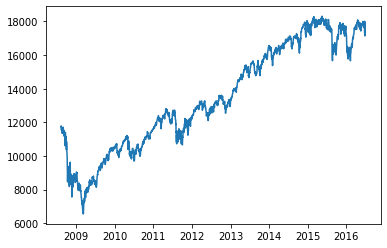

In [77]:
plt.plot(full_test['Date'],full_test['Adj Close'])
plt.show()

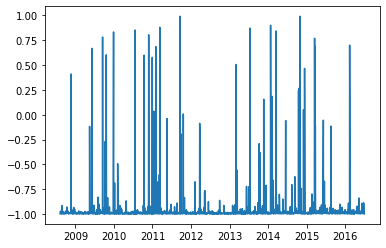

In [78]:
plt.plot(full_test['Date'],full_test['Compound'])
plt.show()

In [ ]:
#Lets do some visualization


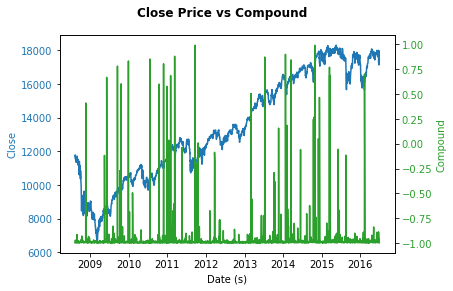

In [80]:
fig, ax1 = plt.subplots()
   
color = 'tab:blue'
ax1.set_xlabel('Date (s)')
ax1.set_ylabel('Close', color = color)
ax1.plot(full_test['Date'], full_test['Adj Close'], color = color)
ax1.tick_params(axis ='y', labelcolor = color)
   
ax2 = ax1.twinx()
   
color = 'tab:green'
ax2.set_ylabel('Compound', color = color)
ax2.plot(full_test['Date'], full_test['Compound'], color = color)
ax2.tick_params(axis ='y', labelcolor = color)
  
fig.suptitle('Close Price vs Compound', fontweight ="bold")
plt.show()


In [ ]:
#add confusion matrix to models

In [81]:
X = full_test
X = np.array(X.drop(['Label*','Date','Combined News'], axis =1))
Y = np.array(full_test['Label*'])

In [82]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=0)

In [83]:
   # normalize X's
x_train = preprocessing.scale(x_train)
x_test = preprocessing.scale(x_test)

    # test models
models = {  'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(),
                'SVM Classification': SVC(),
                'SGDClassifier': SGDClassifier(loss="hinge", penalty="l2", max_iter=75),
                'RandomForestClassifier': RandomForestClassifier(n_estimators=75)
                }

for modeltype in models.keys():

    model = models[modeltype]
    print('* * *',modeltype,'* * *')
    model.fit(x_train,y_train)
    print(classification_report(model.predict(x_test),y_test))
    print(accuracy_score(model.predict(x_test),y_test))
    print(confusion_matrix(y_test,model.predict(x_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


* * * LinearDiscriminantAnalysis * * *
              precision    recall  f1-score   support

           0       0.19      0.41      0.26        59
           1       0.80      0.57      0.67       240

    accuracy                           0.54       299
   macro avg       0.49      0.49      0.46       299
weighted avg       0.68      0.54      0.58       299

0.5384615384615384
[[ 24 103]
 [ 35 137]]
* * * SVM Classification * * *
              precision    recall  f1-score   support

           0       0.12      0.41      0.18        37
           1       0.87      0.57      0.69       262

    accuracy                           0.55       299
   macro avg       0.50      0.49      0.44       299
weighted avg       0.78      0.55      0.63       299

0.5518394648829431
[[ 15 112]
 [ 22 150]]
* * * SGDClassifier * * *
              precision    recall  f1-score   support

           0       0.58      0.45      0.51       166
           1       0.47      0.60      0.52       133

  

In [84]:
comparetest = full_test
comparetest.head()

,Date,Label*,Combined News,Open,Close,Adj Close,Volume,Compound,Positive,Neutral,Negative
0,2008-08-08,1,Georgia downs two Russian warplanes as countri...,11432.089844,11734.320313,11734.320313,212830000,-0.9982,0.041,0.724,0.235
1,2008-08-11,0,Why wont America and Nato help us? If they won...,11729.669922,11782.349609,11782.349609,183190000,-0.9858,0.089,0.721,0.191
2,2008-08-12,0,Remember that adorable 9-year-old who sang at ...,11781.700195,11642.469727,11642.469727,173590000,-0.9715,0.056,0.816,0.128
3,2008-08-13,1,U.S. refuses Israel weapons to attack Iran: r...,11632.809570,11532.959961,11532.959961,182550000,-0.9809,0.066,0.788,0.146
4,2008-08-14,1,All the experts admit that we should legalise ...,11532.070313,11615.929688,11615.929688,159790000,-0.9882,0.094,0.717,0.189


In [85]:
comparetest.shape

(1989, 11)

In [86]:
model_name = "human-centered-summarization/financial-summarization-pegasus"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)
modeltf = TFPegasusForConditionalGeneration.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

All the layers of TFPegasusForConditionalGeneration were initialized from the model checkpoint at human-centered-summarization/financial-summarization-pegasus.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFPegasusForConditionalGeneration for predictions without further training.


In [87]:
comparetest['Combined News'].iloc[1]

'Why wont America and Nato help us? If they wont help us now, why did we help them in Iraq? Bush puts foot down on Georgian conflict Jewish Georgian minister: Thanks to Israeli training, were fending off Russia " Georgian army flees in disarray as Russians advance - Gori abandoned to Russia without a shot fired Olympic opening ceremony fireworks faked" What were the Mossad with fraudulent New Zealand Passports doing in Iraq? Russia angered by Israeli military sale to Georgia An American citizen living in S.Ossetia blames U.S. and Georgian leaders for the genocide of innocent people Welcome To World War IV! Now In High Definition! Georgias move, a mistake of monumental proportions " Russia presses deeper into Georgia; U.S. says regime change is goal Abhinav Bindra wins first ever Individual Olympic Gold Medal for India  U.S. ship heads for Arctic to define territory Drivers in a Jerusalem taxi station threaten to quit rather than work for their new boss - an Ara The French Team is Stunn

In [88]:
input_ids = tokenizer.encode(comparetest['Combined News'].iloc[0], return_tensors='pt')
output = model.generate(input_ids, max_length=55, num_beams=5, early_stopping=True)
summary = tokenizer.decode(output[0], skip_special_tokens=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [89]:
summary

'Georgia invades breakaway region of South Ossetia, shoots down two Russian warplanes.'

In [90]:
summaries = []
for i in range(0,101):
  input_ids = tokenizer.encode(comparetest['Combined News'].iloc[i], return_tensors='tf')
  output = modeltf.generate(input_ids, max_length=71, num_beams=5, early_stopping=True)
  summary = tokenizer.decode(output[0], skip_special_tokens=True)
  summaries.append(summary)


In [91]:
summaries

['Georgia rape two Russian warplanes, Russia invades region of South Ossetia.',
 'Bindra wins first gold medal for India in Olympics.',
 'Russian troops still trying to move into South Ossetia. Russia says war with Georgia was a justified response',
 'Russia, Georgia clash over separatist region of South Ossetia.',
 'War in South Ossetia is as much the product of an American imperial drive as local conflicts.',
 'Some of the key quotes from the week in politics:',
 'Russian warplanes launch new missiles at targets in Georgia.',
 'Russian troops seize Georgia’s capital 10 years after war.',
 'Planes, elderly Chinese sentenced to protest Gulf War over re-education through labor.',
 'Chinese Head of Crackdown may have killed 140 Tibetan sentences.',
 'Russia ready to put a missile system on its soil, Ossetian leader says.',
 'Report: naked guards, drunk, surrounded by sex toys - Israeli report.',
 'Russia votes overwhelmingly to officially recognize Abkhazia, South Ossetia.',
 'A look at 

In [92]:
sentiments = sentiment_analysis(summaries)

In [93]:
type(sentiments)

list

In [94]:
compare101 = comparetest.head(101)

In [95]:
compare101.shape

(101, 11)

In [96]:
compare101['Transformers Sentiment'] = sentiments

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [97]:
compare101.head()

,Date,Label*,Combined News,Open,Close,Adj Close,Volume,Compound,Positive,Neutral,Negative,Transformers Sentiment
0,2008-08-08,1,Georgia downs two Russian warplanes as countri...,11432.089844,11734.320313,11734.320313,212830000,-0.9982,0.041,0.724,0.235,"{'label': 'NEGATIVE', 'score': 0.8975462317466..."
1,2008-08-11,0,Why wont America and Nato help us? If they won...,11729.669922,11782.349609,11782.349609,183190000,-0.9858,0.089,0.721,0.191,"{'label': 'POSITIVE', 'score': 0.9996459484100..."
2,2008-08-12,0,Remember that adorable 9-year-old who sang at ...,11781.700195,11642.469727,11642.469727,173590000,-0.9715,0.056,0.816,0.128,"{'label': 'NEGATIVE', 'score': 0.9629366397857..."
3,2008-08-13,1,U.S. refuses Israel weapons to attack Iran: r...,11632.809570,11532.959961,11532.959961,182550000,-0.9809,0.066,0.788,0.146,"{'label': 'NEGATIVE', 'score': 0.9352225065231..."
4,2008-08-14,1,All the experts admit that we should legalise ...,11532.070313,11615.929688,11615.929688,159790000,-0.9882,0.094,0.717,0.189,"{'label': 'NEGATIVE', 'score': 0.9964773058891..."


In [98]:
def find_sentiment(text):
    if vader.polarity_scores(text)["compound"] > 0:
        return "POSITIVE"
    elif vader.polarity_scores(text)["compound"] < 0:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

In [99]:
vader = SentimentIntensityAnalyzer()

vader_sent = find_sentiment(summaries)

In [100]:
compare101['Vader Sentiment'] = vader_sent

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [101]:
compare101.head(21)

,Date,Label*,Combined News,Open,Close,Adj Close,Volume,Compound,Positive,Neutral,Negative,Transformers Sentiment,Vader Sentiment
0,2008-08-08,1,Georgia downs two Russian warplanes as countri...,11432.089844,11734.320313,11734.320313,212830000,-0.9982,0.041,0.724,0.235,"{'label': 'NEGATIVE', 'score': 0.8975462317466...",NEGATIVE
1,2008-08-11,0,Why wont America and Nato help us? If they won...,11729.669922,11782.349609,11782.349609,183190000,-0.9858,0.089,0.721,0.191,"{'label': 'POSITIVE', 'score': 0.9996459484100...",NEGATIVE
2,2008-08-12,0,Remember that adorable 9-year-old who sang at ...,11781.700195,11642.469727,11642.469727,173590000,-0.9715,0.056,0.816,0.128,"{'label': 'NEGATIVE', 'score': 0.9629366397857...",NEGATIVE
3,2008-08-13,1,U.S. refuses Israel weapons to attack Iran: r...,11632.809570,11532.959961,11532.959961,182550000,-0.9809,0.066,0.788,0.146,"{'label': 'NEGATIVE', 'score': 0.9352225065231...",NEGATIVE
4,2008-08-14,1,All the experts admit that we should legalise ...,11532.070313,11615.929688,11615.929688,159790000,-0.9882,0.094,0.717,0.189,"{'label': 'NEGATIVE', 'score': 0.9964773058891...",NEGATIVE
5,2008-08-15,0,Mom of missing gay man: Too bad hes not a 21-y...,11611.209961,11659.900391,11659.900391,215040000,-0.9892,0.070,0.753,0.177,"{'label': 'POSITIVE', 'score': 0.9957727789878...",NEGATIVE
6,2008-08-18,0,"In an Afghan prison, the majority of female pr...",11659.650391,11479.389648,11479.389648,156290000,-0.9938,0.056,0.719,0.224,"{'label': 'NEGATIVE', 'score': 0.7608084678649...",NEGATIVE
7,2008-08-19,1,Man arrested and locked up for five hours afte...,11478.089844,11348.549805,11348.549805,171580000,-0.9974,0.037,0.716,0.247,"{'label': 'POSITIVE', 'score': 0.9417404532432...",NEGATIVE
8,2008-08-20,1,Two elderly Chinese women have been sentenced ...,11345.940430,11417.429688,11417.429688,144880000,-0.9913,0.060,0.758,0.182,"{'label': 'NEGATIVE', 'score': 0.9648569822311...",NEGATIVE
9,2008-08-21,1,British resident held in Guantanamo Bay wins l...,11415.230469,11430.209961,11430.209961,130020000,-0.9966,0.065,0.717,0.218,"{'label': 'NEGATIVE', 'score': 0.995674729347229}",NEGATIVE


In [102]:
from google.colab import files
compare101.to_csv('compare_nlp.csv') 
files.download('compare_nlp.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>